<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли" data-toc-modified-id="Расчёт-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли</a></span><ul class="toc-item"><li><span><a href="#Выберем-скважины-с-максимальными-значениями-предсказаний" data-toc-modified-id="Выберем-скважины-с-максимальными-значениями-предсказаний-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выберем скважины с максимальными значениями предсказаний</a></span></li><li><span><a href="#Просуммируем-целевое-значение-объёма-сырья,-соответствующее-этим-предсказаниям" data-toc-modified-id="Просуммируем-целевое-значение-объёма-сырья,-соответствующее-этим-предсказаниям-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям</a></span></li><li><span><a href="#Рассчитаем-прибыль-для-полученного-объёма-сырья" data-toc-modified-id="Рассчитаем-прибыль-для-полученного-объёма-сырья-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Рассчитаем прибыль для полученного объёма сырья</a></span></li></ul></li><li><span><a href="#Риски-и-прибыль-для-каждого-региона" data-toc-modified-id="Риски-и-прибыль-для-каждого-региона-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Риски и прибыль для каждого региона</a></span><ul class="toc-item"><li><span><a href="#Применим-технику-Bootstrap-с-1000-выборок,-чтобы-найти-распределение-прибыли" data-toc-modified-id="Применим-технику-Bootstrap-с-1000-выборок,-чтобы-найти-распределение-прибыли-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли</a></span></li><li><span><a href="#Найдем-среднюю-прибыль,-95%-й-доверительный-интервал-и-риск-убытков" data-toc-modified-id="Найдем-среднюю-прибыль,-95%-й-доверительный-интервал-и-риск-убытков-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Импортируем необходимые библиотеки

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Все ключевые значения для расчётов сохраним в отдельных переменных

In [290]:
#При разведке региона исследуют 500 точек
TOTAL_POINTS = 500
#Выбирают 200 лучших для разработки
TOP_POINTS = 200
#Бюджет на разработку скважин в регионе — 10 млрд рублей
REGION_BUDGET = 10000000000
#Тысяча баррелей сырья приносит 450 000 рублей дохода
BARREL_PRICE = 450
BARREL_1000_PRICE = 450000
#Вероятность убытков меньше 2.5%

## Загрузка и подготовка данных

Напишем функцию для получения данных из файла и анализа содержания

In [291]:
def get_data(path):
    df = pd.read_csv(path)
    display(df.info())
    display(df.head())
    display(df.describe().T)
    try: 
        del df['Unnamed: 0'] #удаление лишнего столбца при наличии
    except KeyError:
        print('Unnamed: 0 не обнаружено лишних столбцов')
        print('')
        
    print('столбцов: ', len(df.columns), df.columns) 
        
    for i in range(0, len(df.columns)):
        print('')
        print('уникальные значения столбца ' + str(i) + ' ' + df.columns[i])
        print(df.iloc[:,i].unique())
        print('')
    return df

Применим функцию и посмотрим на уникальность значений файлов, типы данных, пропущенные значения

In [292]:
df1 = get_data('datasets/geo_data_0.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Unnamed: 0 не обнаружено лишних столбцов

столбцов:  5 Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

уникальные значения столбца 0 id
['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']


уникальные значения столбца 1 f0
[0.70574498 1.33471129 1.02273226 ... 1.02958465 0.99816289 1.76475393]


уникальные значения столбца 2 f1
[-0.4978225  -0.34016425  0.15199044 ...  0.01878693 -0.52858167
 -0.26641676]


уникальные значения столбца 3 f2
[ 1.22116995  4.36508033  1.41992624 ... -1.34830814  1.58386866
  5.72284937]


уникальные значения столбца 4 product
[105.28006184  73.03775027  85.26564713 ...  64.37544259  74.04076435
 149.63324561]



In [293]:
df2 = get_data('datasets/geo_data_1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Unnamed: 0 не обнаружено лишних столбцов

столбцов:  5 Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

уникальные значения столбца 0 id
['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']


уникальные значения столбца 1 f0
[-15.00134818  14.27208781   6.26318735 ...  -7.37889139   0.66571381
  -3.42613898]


уникальные значения столбца 2 f1
[-8.27599995 -3.47508322 -5.94838579 ... -3.08410387 -6.15259286
 -7.7942742 ]


уникальные значения столбца 3 f2
[-5.87601369e-03  9.99182737e-01  5.00116016e+00 ...  4.99865060e+00
  1.00014635e+00 -3.29851829e-03]


уникальные значения столбца 4 product
[  3.17910258  26.95326103 134.76630516 137.94540774  84.03888568
 110.99214671  53.90652206   0.         107.81304413  57.08562465
  30.13236361  80.85978309]



In [294]:
df3 = get_data('datasets/geo_data_2.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Unnamed: 0 не обнаружено лишних столбцов

столбцов:  5 Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

уникальные значения столбца 0 id
['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']


уникальные значения столбца 1 f0
[-1.1469871   0.2627779   0.19458728 ... -1.19993432 -2.41989641
 -2.55142066]


уникальные значения столбца 2 f1
[ 0.96332792  0.26983896  0.289035   ... -2.95763723  2.41722066
 -2.02562514]


уникальные значения столбца 3 f2
[-0.82896492 -2.53018652 -5.58643277 ...  5.219411   -5.54844392
  6.09089066]


уникальные значения столбца 4 product
[ 27.75867323  56.06969663  62.87191005 ... 157.08007975  51.79525299
 102.77576749]



Оценим корреляцию данных в таблицах каждого региона

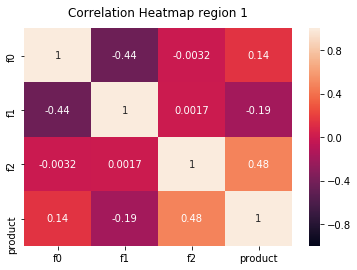

<Figure size 1152x432 with 0 Axes>

In [295]:
heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True);
plt.figure(figsize=(16, 6))
heatmap.set_title('Correlation Heatmap region 1', fontdict={'fontsize':12}, pad=12);

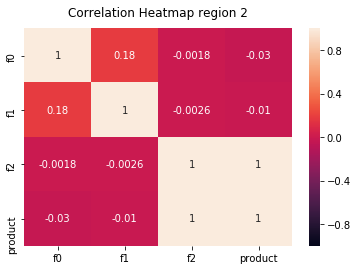

<Figure size 1152x432 with 0 Axes>

In [296]:
heatmap = sns.heatmap(df2.corr(), vmin=-1, vmax=1, annot=True);
plt.figure(figsize=(16, 6))
heatmap.set_title('Correlation Heatmap region 2', fontdict={'fontsize':12}, pad=12);

f2 признак коррелирует с product, необходимо убедиться в достоверности полученных данных

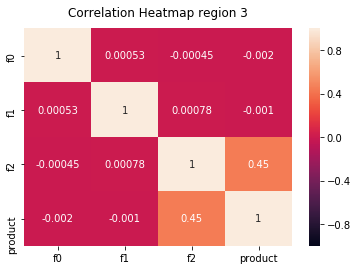

<Figure size 1152x432 with 0 Axes>

In [297]:
heatmap = sns.heatmap(df3.corr(), vmin=-1, vmax=1, annot=True);
plt.figure(figsize=(16, 6))
heatmap.set_title('Correlation Heatmap region 3', fontdict={'fontsize':12}, pad=12);

## Обучение и проверка модели

Напишем функцию для обучения моделей

In [298]:
def split_data(data):  
    model = None
    # 2.1. Разобьем данные на обучающую и валидационную выборки в соотношении 75:25.
    target = data['product']
    features = data.drop(['product', 'id'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(
                                              features, target, test_size=0.25, random_state=12345)
    features_train = features_train.copy()
    features_valid = features_valid.copy()
    print(features_train.shape)
    print(features_valid.shape)
    #2.2. Обучим модель и сделаем предсказания на валидационной выборке.
    model = LinearRegression()
    model.fit(features_train, target_train)
    #2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
    predicted_valid = model.predict(features_valid)
    predicted_valid = pd.Series(predicted_valid)
    #2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
    mse = mean_squared_error(predicted_valid, target_valid)
    mean_pred = round(predicted_valid.mean(), 3)
    print("средний запас предсказанного сырья", mean_pred, "тысяч баррелей")
    print("RMSE =", round(mse ** 0.5, 5))
    return predicted_valid, mean_pred, target_valid

Получим результаты по каждому из регионов

In [299]:
predicted_valid_1, mean_pred_1, target_valid_1 = split_data(df1)

(75000, 3)
(25000, 3)
средний запас предсказанного сырья 92.593 тысяч баррелей
RMSE = 37.57942


In [300]:
predicted_valid_2, mean_pred_2, target_valid_2 = split_data(df2)

(75000, 3)
(25000, 3)
средний запас предсказанного сырья 68.729 тысяч баррелей
RMSE = 0.8931


In [301]:
predicted_valid_3, mean_pred_3, target_valid_3 = split_data(df3)

(75000, 3)
(25000, 3)
средний запас предсказанного сырья 94.965 тысяч баррелей
RMSE = 40.02971


Вывод

Средний запас сырья 1 и 3 регионов приблизительно одинаков, запас предсказанного сырья 2 региона меньше. При этом ошибка предсказаний существенно меньше у 2 региона.

## Подготовка к расчёту прибыли


Подготовимся к расчёту прибыли:

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

Рассчитаем бюджет на разработку одной скважины, он равен общему бюджету на регион поделенному на количество исследуемых скважин.

In [302]:
BUDGET_POINT = REGION_BUDGET/TOP_POINTS
BUDGET_POINT

50000000.0

Стоимость разработки 1 скважины составляет 20 млн. руб.

In [303]:
ZERO_POINT = round(BUDGET_POINT / BARREL_1000_PRICE, 3)
ZERO_POINT

111.111

Объем сырья для безубыточной разработки новой скважины составляет 111,111 тыс. баррелей

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [304]:
print("средний запас предсказанного сырья региона 1:", mean_pred_1)
print("средний запас предсказанного сырья региона 2:", mean_pred_2)
print("средний запас предсказанного сырья региона 3:", mean_pred_3)
print("достаточный объём сырья для безубыточной разработки новой скважины:", ZERO_POINT)

средний запас предсказанного сырья региона 1: 92.593
средний запас предсказанного сырья региона 2: 68.729
средний запас предсказанного сырья региона 3: 94.965
достаточный объём сырья для безубыточной разработки новой скважины: 111.111


**Выводы**

Средние значения запаса предсказанного сырья региона не соответствуют достаточному объему сырья для безубыточной разработки новой скважины

In [305]:
target = df1['product']
features = df1.drop(['product', 'id'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
                                          features, target, test_size=0.25, random_state=12345)
features_train = features_train.copy()
features_valid = features_valid.copy()
print(features_train.shape)
print(features_valid.shape)
#2.2. Обучим модель и сделаем предсказания на валидационной выборке.
model = LinearRegression()
model.fit(features_train, target_train)
#2.3. Сохраним предсказания и правильные ответы на валидационной выборке.
predicted_valid = model.predict(features_valid) 
predicted_valid

(75000, 3)
(25000, 3)


array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

In [306]:
predicted_valid

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

## Расчёт прибыли 

### Выберем скважины с максимальными значениями предсказаний

In [307]:
def calc_top(predicted_valid):
    predicted_valid = pd.Series(predicted_valid)
    predicted_valid = predicted_valid.reset_index()
    predicted_valid.columns = ['index', 'pred_product']
    predicted_valid_top200 = predicted_valid.query('pred_product > @ZERO_POINT').sort_values(by='pred_product', ascending=False).head(200)
    return predicted_valid_top200

In [308]:
predicted_valid_1_top200 = calc_top(predicted_valid_1)
predicted_valid_2_top200 = calc_top(predicted_valid_2)
predicted_valid_3_top200 = calc_top(predicted_valid_3)

In [309]:
display(predicted_valid_1_top200.head())
display(predicted_valid_2_top200.head())
display(predicted_valid_3_top200.head())

,index,pred_product
9317,9317,180.180713
219,219,176.252213
10015,10015,175.850623
11584,11584,175.658429
23388,23388,173.299686


,index,pred_product
20430,20430,139.818970
7777,7777,139.773423
8755,8755,139.703330
1178,1178,139.560938
4285,4285,139.516754


,index,pred_product
22636,22636,165.856833
24690,24690,165.679685
7811,7811,163.439962
1581,1581,162.062589
6751,6751,161.797476


### Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям

Просуммируем объем запасов скважин с максимальным значением предсказаний:

In [310]:
TOTAL_VOL_1 = predicted_valid_1_top200.pred_product.sum()
TOTAL_VOL_1

31102.330838811395

In [311]:
TOTAL_VOL_2 = predicted_valid_2_top200.pred_product.sum()
TOTAL_VOL_2

27746.026782163426

In [312]:
TOTAL_VOL_3 = predicted_valid_3_top200.pred_product.sum()
TOTAL_VOL_3

29603.89865831835

### Рассчитаем прибыль для полученного объёма сырья

Рассчитаем прибыль для полученного объёма сырья для каждого из регионов

In [313]:
INCOME_1 = round(TOTAL_VOL_1*BARREL_1000_PRICE - REGION_BUDGET, 2)
INCOME_2 = round(TOTAL_VOL_2*BARREL_1000_PRICE - REGION_BUDGET, 2)
INCOME_3 = round(TOTAL_VOL_3*BARREL_1000_PRICE - REGION_BUDGET, 2)
print('регион 1:', INCOME_1, 'руб.')
print('регион 2:', INCOME_2, 'руб.')
print('регион 3:', INCOME_3, 'руб.')

регион 1: 3996048877.47 руб.
регион 2: 2485712051.97 руб.
регион 3: 3321754396.24 руб.


## Риски и прибыль для каждого региона

### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли

Напишем функцию для подсчета прибыли 200 скважин с наибольшим запасом сырья в регионе:

In [314]:
def revenue(target_valid, predicted_valid):
    point_sorted = predicted_valid.sort_values(ascending=False)
    selected = target_valid[point_sorted.index][:200]
    return BARREL_1000_PRICE * selected.sum() - REGION_BUDGET

Создадим объект RandomState() из модуля numpy.random. Этот объект передадим аргументу random_state чтобы в каждом новом вызове его состояние менялось на случайное. Так получим разные подвыборки:

In [315]:
state = np.random.RandomState(12345)

In [316]:
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)
target_valid_3 = target_valid_3.reset_index(drop=True)

Процедурой бутстреп создадим 1000 подвыборок, в каждой из подвыборок отберем 500 скважин и функцией revenue выполним подсчет прибыли 200 скважин с наибольшим запасом сырья 

In [317]:
values_1 = []
values_2 = []
values_3 = []
for i in range(1000):    
    target_subsample = target_valid_1.sample(n=500, replace=True, random_state=state)
    predict_subsample = predicted_valid_1[target_subsample.index]
    values_1.append(revenue(target_subsample, predict_subsample))

    target_subsample = target_valid_2.sample(n=500, replace=True, random_state=state)
    predict_subsample = predicted_valid_2[target_subsample.index]
    values_2.append(revenue(target_subsample, predict_subsample))
    
    target_subsample = target_valid_3.sample(n=500, replace=True, random_state=state)
    predict_subsample = predicted_valid_3[target_subsample.index]
    values_3.append(revenue(target_subsample, predict_subsample))

### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков

Напишем функцию для поиска необходимых значений

In [318]:
def calc_mean_quant(values):
    values = pd.Series(values)
    values = values.reset_index()
    values.columns = ['index', 'revenue']
    mean = round(values.revenue.mean(), 2)
    lower = round(values.revenue.quantile(0.025), 2)
    upper = round(values.revenue.quantile(0.975), 2)
    #risk = 100 * values.query('revenue < 0').count() / values.count() 
    risk = 100 * (values < 0).mean()
    print("Средняя прибыль:", mean)
    print("Нижняя граница интервала:", lower)
    print("Верхняя граница интервала:", upper)
    print("Риск убытков:", risk.revenue, "%")
    
    return values

Регион 1

In [319]:
values_1 = calc_mean_quant(values_1)

Средняя прибыль: 414736268.61
Нижняя граница интервала: -123528116.45
Верхняя граница интервала: 968562865.5
Риск убытков: 7.000000000000001 %


Посмотрим на распределение прибыли в регионе

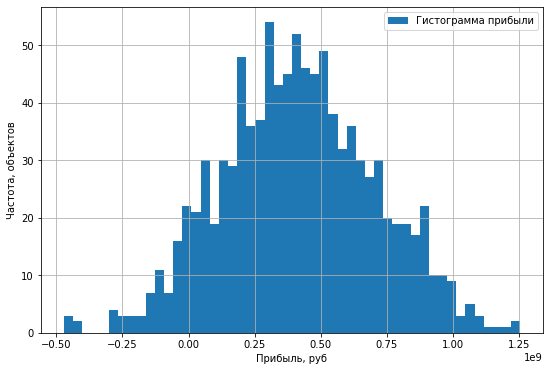

In [320]:
ax = values_1.plot(
    kind='hist',
    y='revenue',
    bins=50,
    label='Гистограмма прибыли',
    grid=True,
    legend=True,
    figsize=(9,6)
)

#Добавляем подписи к осям:
ax.set_xlabel('Прибыль, руб')
ax.set_ylabel('Частота, объектов')
plt.show()

Регион 2

In [321]:
values_2 = calc_mean_quant(values_2)

Средняя прибыль: 513172169.34
Нижняя граница интервала: 85329746.23
Верхняя граница интервала: 940106288.3
Риск убытков: 0.8999999999999999 %


Посмотрим на распределение прибыли в регионе

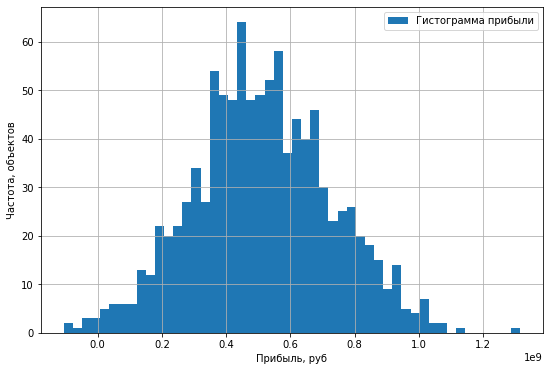

In [322]:
ax = values_2.plot(
    kind='hist',
    y='revenue',
    bins=50,
    label='Гистограмма прибыли',
    grid=True,
    legend=True,
    figsize=(9,6)
)

#Добавляем подписи к осям:
ax.set_xlabel('Прибыль, руб')
ax.set_ylabel('Частота, объектов')
plt.show()

Регион 3

In [323]:
values_3 = calc_mean_quant(values_3)

Средняя прибыль: 410198401.27
Нижняя граница интервала: -140423727.25
Верхняя граница интервала: 967716156.98
Риск убытков: 8.5 %


Посмотрим на распределение прибыли в регионе

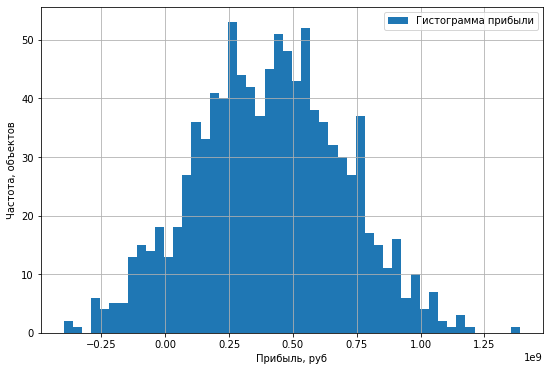

In [324]:
ax = values_3.plot(
    kind='hist',
    y='revenue',
    bins=50,
    label='Гистограмма прибыли',
    grid=True,
    legend=True,
    figsize=(9,6)
)

#Добавляем подписи к осям:
ax.set_xlabel('Прибыль, руб')
ax.set_ylabel('Частота, объектов')
plt.show()

### Вывод

На основании предоставленных проб нефти в трёх регионах построили модель для определения региона, с наибольшей прибылью. Наиболее подходящий регион для разработки под номером 2. Оценили среднюю прибыль. Нашли 95%-й доверительный интервал. Вероятность убытков 0,9%. По требованию отбора региона с риском менее 2.5% регион подходит.